# Universal Adversarial Audio Attack on Whisper

**Proof of Concept**: Creating a universal noise pattern that, when added to any audio, causes Whisper to mistranscribe.

In [14]:
import random
from pathlib import Path

import torch
import whisper
import librosa
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from jiwer import wer

In [15]:
# Configuration
LIBRISPEECH_PATH = Path("LibriSpeech/test-clean")
SAMPLE_RATE = 16000  # Whisper's expected sample rate
MAX_SAMPLES = 25     # Number of audio samples to test (reduced for faster testing)
MODEL = "base"  # Whisper model size, can be "tiny", "base", "small", "medium", "large"

# General Attack Parameters
ITERATIONS = 250
LEARNING_RATE = 0.01
EPSILON = 0.02

# Fast Feature Fool (FFF) specific parameters
ATTACK_LAYERS = [
    'encoder.conv1',
    'encoder.conv2',
    'encoder.blocks.2.attn',
    'encoder.blocks.4.attn'
]

# PSP-UAP specific parameters
PSP_LAMBDA_PERCEPTUAL = 1.0  # Weight for the perceptual loss component
PSP_LAMBDA_FOOLING = 1.0     # Weight for the fooling loss component

# Load Whisper model
model = whisper.load_model(MODEL)
print(f"Loaded Whisper {MODEL} model")

# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)
random.seed(42)

Loaded Whisper base model


In [16]:
def load_librispeech_samples(data_path, max_samples=20):
    """Load audio files and transcriptions from LibriSpeech dataset"""
    samples = []

    if not data_path.exists():
        return samples

    # Iterate through speaker directories
    for speaker_dir in data_path.iterdir():
        if not speaker_dir.is_dir():
            continue

        # Iterate through chapter directories
        for chapter_dir in speaker_dir.iterdir():
            if not chapter_dir.is_dir():
                continue

            # Load transcription file
            speaker_id = speaker_dir.name
            chapter_id = chapter_dir.name
            trans_file = chapter_dir / f"{speaker_id}-{chapter_id}.trans.txt"
            if not trans_file.exists():
                continue

            # Parse transcriptions
            transcriptions = {}
            with open(trans_file, 'r') as f:
                for line in f:
                    parts = line.strip().split(' ', 1)
                    if len(parts) == 2:
                        transcriptions[parts[0]] = parts[1]

            # Load audio files
            for audio_file in chapter_dir.glob("*.flac"):
                if len(samples) >= max_samples:
                    return samples

                file_id = audio_file.stem
                if file_id in transcriptions:
                    try:
                        audio, _ = librosa.load(audio_file, sr=SAMPLE_RATE)
                        samples.append({
                            'id': file_id,
                            'audio': audio,
                            'transcript': transcriptions[file_id],
                            'path': str(audio_file)
                        })
                    except Exception:
                        continue

    return samples

# Load samples
samples = load_librispeech_samples(LIBRISPEECH_PATH, MAX_SAMPLES)
print(f"Loaded {len(samples)} audio samples")

Loaded 25 audio samples


In [17]:
class FastFeatureFoolAttack:
    """
    Fast Feature Fool (FFF) attack adapted for Whisper.
    """
    def __init__(self, model, attack_layers, epsilon=0.02, learning_rate=0.01, iterations=100,
                 data_assisted=False, batch_size=4, log_eps=1e-6):
        self.model = model
        self.attack_layers = attack_layers
        self.epsilon = epsilon
        self.learning_rate = learning_rate
        self.iterations = iterations
        self.data_assisted = data_assisted
        self.batch_size = batch_size
        self.log_eps = log_eps
        self.hooks = []
        self.features = {}
        self.device = next(model.parameters()).device

    def _get_feature_hook(self, name):
        def hook(model, input, output):
            # Store post-module activation tensor
            self.features[name] = output[0] if isinstance(output, tuple) else output
        return hook

    def _register_hooks(self):
        for name, module in self.model.named_modules():
            if name in self.attack_layers:
                self.hooks.append(module.register_forward_hook(self._get_feature_hook(name)))

    def _remove_hooks(self):
        for hook in self.hooks:
            hook.remove()
        self.hooks = []

    @torch.no_grad()
    def _estimate_needed_length(self, audio_samples):
        if audio_samples:
            return max(len(a) for a in audio_samples)
        # Fallback to Whisper context length if no samples
        return whisper.audio.N_SAMPLES

    def _forward_with_signal(self, signal):
        """Run encoder forward pass given a 1-D waveform tensor (already on device)."""
        n_samples_ctx = whisper.audio.N_SAMPLES
        if signal.shape[0] > n_samples_ctx:
            sig = signal[:n_samples_ctx]
        else:
            sig = torch.nn.functional.pad(signal, (0, n_samples_ctx - signal.shape[0]))
        mel = whisper.log_mel_spectrogram(sig)
        _ = self.model.encoder(mel.unsqueeze(0).to(self.device))

    def generate(self, audio_samples=None, sample_rate=16000):
        print("Generating universal perturbation with Fast Feature Fool (data_free={} )...".format(
            not self.data_assisted))
        if audio_samples is None:
            audio_samples = []
        self._register_hooks()

        target_len = self._estimate_needed_length(audio_samples)
        # Initialize perturbation uniformly within [-epsilon, epsilon]
        perturbation = torch.empty(target_len, device=self.device).uniform_(-self.epsilon, self.epsilon)
        perturbation.requires_grad_(True)
        optimizer = torch.optim.Adam([perturbation], lr=self.learning_rate)

        pbar = tqdm(range(self.iterations), desc="FFF Iterations")
        for _ in pbar:
            optimizer.zero_grad()
            self.features.clear()

            if self.data_assisted and audio_samples:
                # Choose a mini-batch and accumulate activations after applying δ
                batch = random.sample(audio_samples, min(len(audio_samples), self.batch_size))
                for audio in batch:
                    audio_tensor = torch.tensor(audio, dtype=torch.float32, device=self.device)
                    if len(perturbation) >= len(audio_tensor):
                        pert = perturbation[:len(audio_tensor)]
                    else:
                        # Tile perturbation
                        repeats = (len(audio_tensor) + len(perturbation) - 1) // len(perturbation)
                        pert = perturbation.repeat(repeats)[:len(audio_tensor)]
                    attacked = torch.clamp(audio_tensor + pert, -1.0, 1.0)
                    self._forward_with_signal(attacked)
            else:
                # Pure data-free mode: feed perturbation as a standalone waveform (optionally add silence)
                self._forward_with_signal(torch.clamp(perturbation, -self.epsilon, self.epsilon))

            # Compute paper-aligned objective: maximize product of mean activations
            # => minimize negative sum log(mean + eps)
            if not self.features:
                # Safety: avoid zero division
                continue
            log_means = []
            for name, feat in self.features.items():
                # ReLU may have been applied inside layer; ensure non-negativity for log stability
                mean_act = torch.mean(torch.relu(feat).float())
                log_means.append(torch.log(mean_act + self.log_eps))
            obj = -torch.stack(log_means).sum()  # negative so we minimize
            obj.backward()
            optimizer.step()
            # Enforce L_infinity bound
            with torch.no_grad():
                perturbation.clamp_(-self.epsilon, self.epsilon)
            pbar.set_postfix({"loss": float(obj.detach().cpu())})

        self._remove_hooks()
        print("Finished generating FFF perturbation.")
        return perturbation.detach().cpu().numpy()


class GDUAPAttack:
    """
    GD-UAP (Generalizable Data-free UAP) adapted to Whisper (data-free objective).
    """
    def __init__(self, model, attack_layers=None, epsilon=0.02, learning_rate=0.01, iterations=100,
                 prior='gaussian', samples_per_iter=4, log_eps=1e-6, seed=0):
        self.model = model
        self.attack_layers = attack_layers or []
        self.epsilon = epsilon
        self.learning_rate = learning_rate
        self.iterations = iterations
        self.prior = prior
        self.samples_per_iter = samples_per_iter
        self.log_eps = log_eps
        self.device = next(model.parameters()).device
        self.hooks = []
        self.features = {}
        random.seed(seed)
        np.random.seed(seed)
        torch.manual_seed(seed)

    def _get_feature_hook(self, name):
        def hook(model, input, output):
            self.features.setdefault(name, [])
            self.features[name].append(output[0] if isinstance(output, tuple) else output)
        return hook

    def _register_hooks(self):
        if not self.attack_layers:
            # default: use same layers as FFF if not provided
            for name, _ in self.model.named_modules():
                if any(k in name for k in ['encoder.conv', 'encoder.blocks']):
                    self.attack_layers.append(name)
        for name, module in self.model.named_modules():
            if name in self.attack_layers:
                self.hooks.append(module.register_forward_hook(self._get_feature_hook(name)))

    def _remove_hooks(self):
        for h in self.hooks:
            h.remove()
        self.hooks = []

    def _sample_prior(self, length):
        if self.prior == 'gaussian':
            return torch.randn(length, device=self.device) * 0.05  # small variance
        if self.prior == 'uniform':
            return torch.empty(length, device=self.device).uniform_(-0.05, 0.05)
        if self.prior == 'pink':
            # Fallback simple pink-like noise using FFT if available
            try:
                freqs = torch.fft.rfft(torch.randn(length, device=self.device))
                mag = torch.linspace(1, freqs.shape[0], freqs.shape[0], device=self.device)
                freqs = freqs / mag.clamp_min(1.0)
                signal = torch.fft.irfft(freqs, n=length)
                return signal / signal.abs().max().clamp_min(1e-6) * 0.05
            except Exception:
                return torch.randn(length, device=self.device) * 0.05
        return torch.zeros(length, device=self.device)

    def _forward(self, waveform):
        n_ctx = whisper.audio.N_SAMPLES
        if waveform.numel() > n_ctx:
            w = waveform[:n_ctx]
        else:
            w = torch.nn.functional.pad(waveform, (0, n_ctx - waveform.numel()))
        mel = whisper.log_mel_spectrogram(w)
        _ = self.model.encoder(mel.unsqueeze(0))

    def generate(self, audio_samples=None, sample_rate=16000):
        print("Generating universal perturbation with GD-UAP (data-free)...")
        target_len = whisper.audio.N_SAMPLES if not audio_samples else max(len(s['audio']) for s in audio_samples)
        perturbation = torch.empty(target_len, device=self.device).uniform_(-self.epsilon, self.epsilon)
        perturbation.requires_grad_(True)
        optimizer = torch.optim.Adam([perturbation], lr=self.learning_rate)
        self._register_hooks()

        pbar = tqdm(range(self.iterations), desc="GD-UAP Iterations")
        for _ in pbar:
            optimizer.zero_grad()
            self.features.clear()
            # Draw prior samples
            for _k in range(self.samples_per_iter):
                z = self._sample_prior(target_len)
                x = (z + perturbation).clamp(-1.0, 1.0)
                self._forward(x)
            # Compute loss
            losses = []
            for name, acts_list in self.features.items():
                acts = torch.stack([torch.relu(a).float().mean() for a in acts_list])  # scalar per sample
                mean_act = acts.mean()
                losses.append(torch.log(mean_act + self.log_eps))
            if not losses:
                continue
            obj = -torch.stack(losses).sum()
            obj.backward()
            optimizer.step()
            with torch.no_grad():
                perturbation.clamp_(-self.epsilon, self.epsilon)
            pbar.set_postfix({"loss": float(obj.detach().cpu())})

        self._remove_hooks()
        print("Finished generating GD-UAP perturbation.")
        return perturbation.detach().cpu().numpy()


class PSPUAPAttack:
    """
    PSP-UAP (Pseudo-Semantic Prior UAP) adapted to audio / Whisper.
    """
    def __init__(self, model, attack_layers=None, epsilon=0.02, learning_rate=0.01, iterations=100,
                 semantic_samples=4, crop_min_ratio=0.4, crop_max_ratio=0.9,
                 log_eps=1e-6, kl_eps=1e-8, seed=0):
        self.model = model
        self.attack_layers = attack_layers or []
        self.epsilon = epsilon
        self.learning_rate = learning_rate
        self.iterations = iterations
        self.semantic_samples = semantic_samples
        self.crop_min_ratio = crop_min_ratio
        self.crop_max_ratio = crop_max_ratio
        self.log_eps = log_eps
        self.kl_eps = kl_eps
        self.device = next(model.parameters()).device
        self.hooks = []
        self.features = {}
        random.seed(seed)
        np.random.seed(seed)
        torch.manual_seed(seed)
        self.tokenizer = whisper.tokenizer.get_tokenizer(model.is_multilingual, language="en", task="transcribe")
        if hasattr(self.tokenizer, 'sot_sequence'):
            try:
                self.sot_tokens = list(self.tokenizer.sot_sequence())
            except TypeError:
                self.sot_tokens = list(self.tokenizer.sot_sequence)
        elif hasattr(self.tokenizer, 'sot'):
            self.sot_tokens = [self.tokenizer.sot]
        else:
            self.sot_tokens = [getattr(self.tokenizer, 'startoftranscript', 50258)]

    def _get_feature_hook(self, name):
        def hook(model, input, output):
            self.features.setdefault(name, [])
            self.features[name].append(output[0] if isinstance(output, tuple) else output)
        return hook

    def _register_hooks(self):
        if not self.attack_layers:
            for name, _ in self.model.named_modules():
                if any(k in name for k in ['encoder.conv', 'encoder.blocks']):
                    self.attack_layers.append(name)
        for name, module in self.model.named_modules():
            if name in self.attack_layers:
                self.hooks.append(module.register_forward_hook(self._get_feature_hook(name)))

    def _remove_hooks(self):
        for h in self.hooks:
            h.remove()
        self.hooks = []

    def _time_scale(self, x, scale):
        import torch.nn.functional as F
        target_len = max(1, int(round(x.numel() * scale)))
        x2 = x.view(1, 1, -1)
        scaled = F.interpolate(x2, size=target_len, mode='linear', align_corners=False).view(-1)
        return scaled

    def _time_shift(self, x, shift):
        shift = shift % x.numel()
        if shift == 0:
            return x
        return torch.cat([x[-shift:], x[:-shift]])

    def _block_shuffle(self, x, m=8):
        L = x.numel()
        blk_len = L // m
        if blk_len == 0:
            return x
        trimmed = x[:blk_len * m].view(m, blk_len)
        perm = torch.randperm(m, device=x.device)
        shuffled = trimmed[perm].reshape(-1)
        if shuffled.numel() < L:
            shuffled = torch.cat([shuffled, x[shuffled.numel():]])
        return shuffled

    def _apply_random_transform(self, x):
        choice = random.choice(['scale', 'shift', 'shuffle'])
        if choice == 'scale':
            scale = random.uniform(0.8, 1.2)
            out = self._time_scale(x, scale)
            if out.numel() > x.numel():
                out = out[:x.numel()]
            elif out.numel() < x.numel():
                out = torch.nn.functional.pad(out, (0, x.numel() - out.numel()))
            return out
        if choice == 'shift':
            shift = random.randint(0, x.numel()-1)
            return self._time_shift(x, shift)
        m = 2**int(np.floor(np.log2( max(2, x.numel() // 1000) )))
        m = max(2, min(32, m))
        return self._block_shuffle(x, m)

    def _forward_encoder(self, waveform):
        n_ctx = whisper.audio.N_SAMPLES
        if waveform.numel() > n_ctx:
            w = waveform[:n_ctx]
        else:
            w = torch.nn.functional.pad(waveform, (0, n_ctx - waveform.numel()))
        mel = whisper.log_mel_spectrogram(w)
        enc = self.model.encoder(mel.unsqueeze(0))  # (1, T, D)
        return enc, mel

    def _first_step_probs(self, enc):
        if not self.sot_tokens:
            raise RuntimeError("SOT token list is empty; cannot compute first-step probabilities.")
        sot_ints = [int(t) for t in self.sot_tokens]
        tokens_in = torch.tensor([sot_ints], device=self.device, dtype=torch.long)
        logits = self.model.decoder(tokens_in, enc)
        if isinstance(logits, dict) and 'logits' in logits:
            logits = logits['logits']
        logits = logits[:, -1, :]
        return torch.softmax(logits, dim=-1).squeeze(0)

    def generate(self, audio_samples=None, sample_rate=16000):
        print("Generating universal perturbation with PSP-UAP (pseudo-semantic prior)...")
        target_len = whisper.audio.N_SAMPLES if not audio_samples else max(len(s['audio']) for s in audio_samples)
        perturbation = torch.empty(target_len, device=self.device).uniform_(-self.epsilon, self.epsilon)
        perturbation.requires_grad_(True)
        optimizer = torch.optim.Adam([perturbation], lr=self.learning_rate)
        self._register_hooks()

        pbar = tqdm(range(self.iterations), desc="PSP-UAP Iterations")
        for _ in pbar:
            optimizer.zero_grad()
            self.features.clear()
            weights = []
            base_noise = torch.randn(target_len, device=self.device) * 0.05
            pseudo = (base_noise + perturbation.detach()).clamp(-1.0, 1.0)
            for k in range(self.semantic_samples):
                ratio = random.uniform(self.crop_min_ratio, self.crop_max_ratio)
                seg_len = max(8, int(target_len * ratio))
                start = random.randint(0, max(0, target_len - seg_len))
                segment = pseudo[start:start+seg_len]
                segment_resized = self._time_scale(segment, target_len / segment.numel())
                if segment_resized.numel() > target_len:
                    segment_resized = segment_resized[:target_len]
                elif segment_resized.numel() < target_len:
                    segment_resized = torch.nn.functional.pad(segment_resized, (0, target_len - segment_resized.numel()))
                transformed = self._apply_random_transform(segment_resized).clamp(-1.0, 1.0)
                with torch.no_grad():
                    enc_clean, _ = self._forward_encoder(transformed)
                    P = self._first_step_probs(enc_clean)
                adv_wave = (transformed + perturbation).clamp(-1.0, 1.0)
                enc_adv, _ = self._forward_encoder(adv_wave)
                Q = self._first_step_probs(enc_adv)
                kl = torch.sum(P * (torch.log(P + self.kl_eps) - torch.log(Q + self.kl_eps)))
                w = 1.0 / (kl + 1e-6)
                weights.append(w)
                # Remove clean activation entries so only adversarial activations remain (1 per sample)
                for name, acts_list in self.features.items():
                    if len(acts_list) >= 2:
                        # Each sample adds two entries (clean, adv); drop the clean one (second last after append)
                        clean_idx = -2
                        if len(acts_list) >= 2:
                            acts_list.pop(clean_idx)
            layer_terms = []
            for name, acts_list in self.features.items():
                stacked = [torch.relu(a).float().view(-1) for a in acts_list]
                # Sanity: ensure counts match semantic_samples
                if len(stacked) != len(weights):
                    # Truncate to min length
                    m = min(len(stacked), len(weights))
                    stacked = stacked[:m]
                    weights = weights[:m]
                norms = torch.stack([s.norm(2) for s in stacked])
                w_vec = torch.stack(weights)
                weighted = (w_vec * norms).mean()
                layer_terms.append(torch.log(weighted + self.log_eps))
            if not layer_terms:
                continue
            loss = -torch.stack(layer_terms).sum()
            loss.backward()
            optimizer.step()
            with torch.no_grad():
                perturbation.clamp_(-self.epsilon, self.epsilon)
            pbar.set_postfix({"loss": float(loss.detach().cpu())})

        self._remove_hooks()
        print("Finished generating PSP-UAP perturbation.")
        return perturbation.detach().cpu().numpy()

print("Setting up attacks...")
fff_attack = FastFeatureFoolAttack(model, ATTACK_LAYERS, epsilon=EPSILON, learning_rate=LEARNING_RATE, iterations=ITERATIONS,
                                   data_assisted=False)

gduap_attack = GDUAPAttack(model, attack_layers=ATTACK_LAYERS, epsilon=EPSILON, learning_rate=LEARNING_RATE, iterations=ITERATIONS)
pspuap_attack = PSPUAPAttack(model, attack_layers=ATTACK_LAYERS, epsilon=EPSILON, learning_rate=LEARNING_RATE, iterations=ITERATIONS,
                             semantic_samples=3)
clean_audio_list = [sample['audio'] for sample in samples]
noise_patterns = {
    'fff': fff_attack.generate(clean_audio_list, SAMPLE_RATE),
    'gduap': gduap_attack.generate(samples, SAMPLE_RATE),
    'pspuap': pspuap_attack.generate(samples, SAMPLE_RATE)
}
print("\nGenerated noise patterns:")
for name, noise in noise_patterns.items():
    print(f"  {name}: amplitude range [{noise.min():.4f}, {noise.max():.4f}]")

Setting up attacks...
Generating universal perturbation with Fast Feature Fool (data_free=True )...


FFF Iterations: 100%|██████████| 250/250 [04:40<00:00,  1.12s/it, loss=6.94]


Finished generating FFF perturbation.
Generating universal perturbation with GD-UAP (data-free)...


GD-UAP Iterations: 100%|██████████| 250/250 [21:50<00:00,  5.24s/it, loss=8.66]


Finished generating GD-UAP perturbation.
Generating universal perturbation with PSP-UAP (pseudo-semantic prior)...


PSP-UAP Iterations: 100%|██████████| 250/250 [26:10<00:00,  6.28s/it, loss=-49.7]

Finished generating PSP-UAP perturbation.

Generated noise patterns:
  fff: amplitude range [-0.0200, 0.0200]
  gduap: amplitude range [-0.0200, 0.0200]
  pspuap: amplitude range [-0.0200, 0.0200]


In [18]:
def apply_adversarial_noise(audio, noise):
    """Apply universal noise to audio sample"""
    # Truncate or pad noise to match audio length
    if len(noise) > len(audio):
        noise_trimmed = noise[:len(audio)]
    else:
        noise_trimmed = np.pad(noise, (0, len(audio) - len(noise)), mode='wrap')

    # Add noise to audio
    attacked_audio = audio + noise_trimmed

    # Ensure audio stays in valid range [-1, 1]
    attacked_audio = np.clip(attacked_audio, -1.0, 1.0)

    return attacked_audio

# Apply all attack methods to all samples
print("Applying different adversarial noise patterns to all samples...")

for sample in tqdm(samples, desc="Processing samples"):
    # Apply each attack method
    for attack_name, noise_pattern in noise_patterns.items():
        attacked_audio = apply_adversarial_noise(sample['audio'], noise_pattern)
        sample[f'attacked_audio_{attack_name}'] = attacked_audio

print(f"Applied {len(noise_patterns)} different attack methods to all samples")

Applying different adversarial noise patterns to all samples...


Processing samples: 100%|██████████| 25/25 [00:00<00:00, 956.56it/s]

Applied 3 different attack methods to all samples


In [19]:
def transcribe_batch(model, audio_list, batch_name=""):
    """Transcribe a batch of audio samples using Whisper"""
    transcriptions = []

    print(f"Transcribing {len(audio_list)} {batch_name} samples...")
    for audio in tqdm(audio_list, desc=f"Transcribing {batch_name}"):
        try:
            # Ensure audio is float32 and normalized
            audio = np.array(audio, dtype=np.float32)
            
            # Normalize audio to [-1, 1] range if needed
            if np.max(np.abs(audio)) > 1.0:
                audio = audio / np.max(np.abs(audio))
            
            result = model.transcribe(audio, fp16=False)
            transcriptions.append(result['text'].strip().upper())
        except Exception as e:
            print(f"Transcription error: {e}")
            transcriptions.append("")

    return transcriptions

# Transcribe clean audio
clean_audio_list = [sample['audio'] for sample in samples]
clean_transcriptions = transcribe_batch(model, clean_audio_list, "clean")

# Store clean transcriptions
for i, sample in enumerate(samples):
    sample['clean_prediction'] = clean_transcriptions[i]

# Transcribe attacked audio for each method
attack_transcriptions = {}
for attack_name in noise_patterns.keys():
    attacked_audio_list = [sample[f'attacked_audio_{attack_name}'] for sample in samples]
    attack_transcriptions[attack_name] = transcribe_batch(model, attacked_audio_list, f"attacked ({attack_name})")
    
    # Store transcriptions in samples
    for i, sample in enumerate(samples):
        sample[f'attacked_prediction_{attack_name}'] = attack_transcriptions[attack_name][i]

print("All transcriptions completed")


Transcribing 25 clean samples...


Transcribing clean: 100%|██████████| 25/25 [00:34<00:00,  1.38s/it]


Transcribing 25 attacked (fff) samples...


Transcribing attacked (fff): 100%|██████████| 25/25 [00:36<00:00,  1.45s/it]


Transcribing 25 attacked (gduap) samples...


Transcribing attacked (gduap): 100%|██████████| 25/25 [00:33<00:00,  1.35s/it]


Transcribing 25 attacked (pspuap) samples...


Transcribing attacked (pspuap): 100%|██████████| 25/25 [00:33<00:00,  1.32s/it]

All transcriptions completed


In [20]:
# Calculate WER for all samples and attack methods
results = []

for sample in samples:
    ground_truth = sample['transcript'].upper()
    clean_pred = sample['clean_prediction']
    clean_wer = wer(ground_truth, clean_pred)
    
    result_row = {
        'id': sample['id'],
        'ground_truth': ground_truth,
        'clean_prediction': clean_pred,
        'clean_wer': clean_wer,
    }
    
    # Add results for each attack method
    for attack_name in noise_patterns.keys():
        attacked_pred = sample[f'attacked_prediction_{attack_name}']
        attacked_wer = wer(ground_truth, attacked_pred)
        wer_increase = attacked_wer - clean_wer
        
        result_row[f'attacked_prediction_{attack_name}'] = attacked_pred
        result_row[f'attacked_wer_{attack_name}'] = attacked_wer
        result_row[f'wer_increase_{attack_name}'] = wer_increase
    
    results.append(result_row)

# Create results DataFrame
df_results = pd.DataFrame(results)

# Calculate summary statistics
print("EVALUATION RESULTS:")
print("=" * 60)

avg_clean_wer = df_results['clean_wer'].mean()
print(f"Average Clean WER: {avg_clean_wer:.3f} ({avg_clean_wer*100:.1f}%)")
print()

attack_summary = {}
for attack_name in noise_patterns.keys():
    avg_attacked_wer = df_results[f'attacked_wer_{attack_name}'].mean()
    avg_wer_increase = df_results[f'wer_increase_{attack_name}'].mean()
    success_rate = (df_results[f'wer_increase_{attack_name}'] > 0).mean() * 100
    
    attack_summary[attack_name] = {
        'avg_wer': avg_attacked_wer,
        'avg_increase': avg_wer_increase,
        'success_rate': success_rate
    }
    
    print(f"{attack_name.upper()} ATTACK:")
    print(f"  Average WER: {avg_attacked_wer:.3f} ({avg_attacked_wer*100:.1f}%)")
    print(f"  Average WER Increase: {avg_wer_increase:.3f} ({avg_wer_increase*100:.1f}%)")
    print(f"  Success Rate: {success_rate:.1f}% (samples with WER increase > 0)")
    print()

# Find the most effective attack
best_attack = max(attack_summary.items(), key=lambda x: x[1]['avg_increase'])
print(f"MOST EFFECTIVE ATTACK: {best_attack[0].upper()}")
print(f"  WER Increase: {best_attack[1]['avg_increase']:.3f} ({best_attack[1]['avg_increase']*100:.1f}%)")


EVALUATION RESULTS:
Average Clean WER: 0.180 (18.0%)

FFF ATTACK:
  Average WER: 0.285 (28.5%)
  Average WER Increase: 0.105 (10.5%)
  Success Rate: 80.0% (samples with WER increase > 0)

GDUAP ATTACK:
  Average WER: 0.271 (27.1%)
  Average WER Increase: 0.090 (9.0%)
  Success Rate: 64.0% (samples with WER increase > 0)

PSPUAP ATTACK:
  Average WER: 0.218 (21.8%)
  Average WER Increase: 0.038 (3.8%)
  Success Rate: 56.0% (samples with WER increase > 0)

MOST EFFECTIVE ATTACK: FFF
  WER Increase: 0.105 (10.5%)


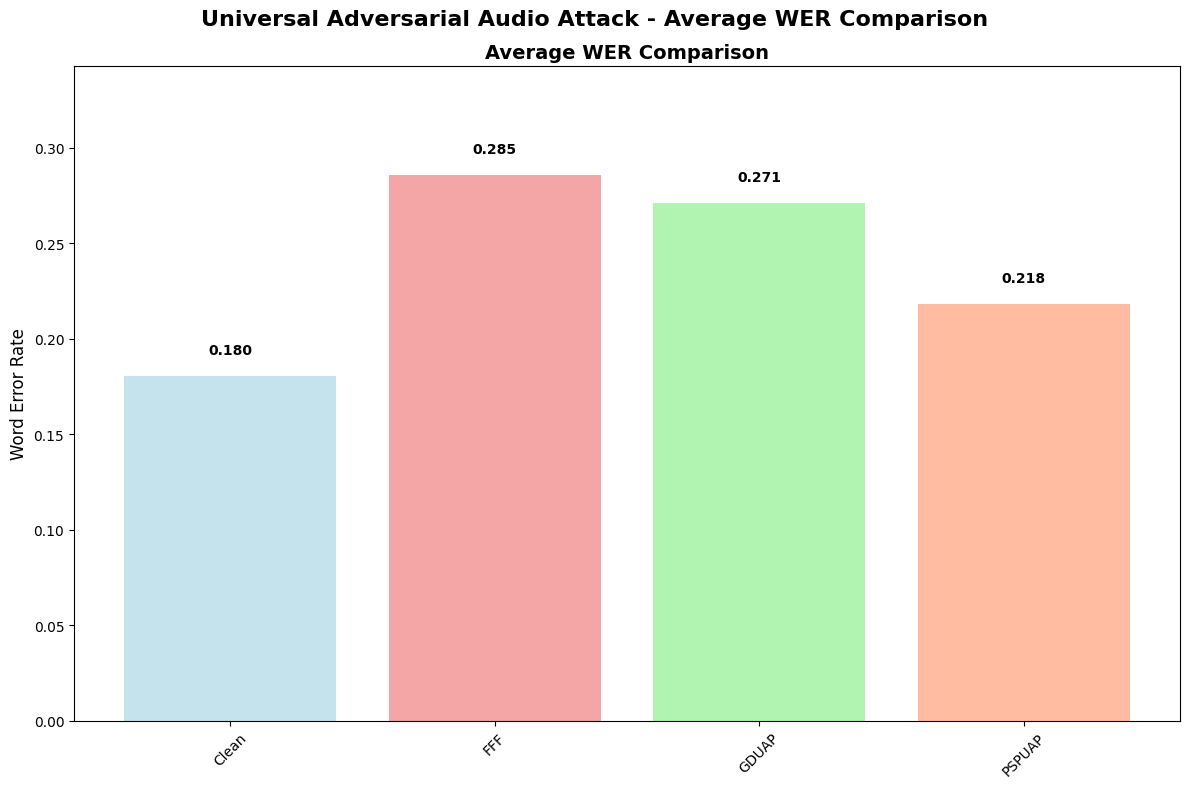

In [21]:
# Create WER comparison visualization
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
fig.suptitle('Universal Adversarial Audio Attack - Average WER Comparison', fontsize=16, fontweight='bold')

# WER Comparison (Bar Plot)
categories = ['Clean'] + [name.upper() for name in noise_patterns.keys()]
wer_values = [avg_clean_wer] + [attack_summary[name]['avg_wer'] for name in noise_patterns.keys()]
colors = ['lightblue'] + ['lightcoral', 'lightgreen', 'lightsalmon']

bars = ax.bar(categories, wer_values, color=colors[:len(categories)], alpha=0.7)
ax.set_ylabel('Word Error Rate', fontsize=12)
ax.set_title('Average WER Comparison', fontweight='bold', fontsize=14)
ax.set_ylim(0, max(wer_values) * 1.2 if wer_values else 1)
ax.tick_params(axis='x', rotation=45)

for bar, val in zip(bars, wer_values):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
             f'{val:.3f}', ha='center', va='bottom', fontweight='bold', fontsize=10)

plt.tight_layout()
plt.show()


In [22]:
# Audio Playback - Listen to Clean vs Attacked Audio
from IPython.display import Audio, display

def play_audio_comparison(sample_idx=0):
    """Play clean, attacked, and noise audio for comparison"""
    sample = samples[sample_idx]

    # Play clean audio
    print("\nCLEAN AUDIO:")
    print(f"  Ground Truth: {sample['transcript'].upper()}")
    print(f"  Whisper Prediction: {sample['clean_prediction']}")
    display(Audio(sample['audio'], rate=SAMPLE_RATE))

    # Play each attacked version and its corresponding noise
    for attack_name, noise_pattern in noise_patterns.items():
        attacked_audio = sample[f'attacked_audio_{attack_name}']
        print(f"\n{attack_name.upper()} ATTACKED AUDIO:")
        print(f"  Whisper Prediction: {sample[f'attacked_prediction_{attack_name}']}")
        display(Audio(attacked_audio, rate=SAMPLE_RATE))

play_audio_comparison(0)


CLEAN AUDIO:
  Ground Truth: HE HOPED THERE WOULD BE STEW FOR DINNER TURNIPS AND CARROTS AND BRUISED POTATOES AND FAT MUTTON PIECES TO BE LADLED OUT IN THICK PEPPERED FLOUR FATTENED SAUCE
  Whisper Prediction: HE HOPED THERE WOULD BE STEW FOR DINNER, TURNIPS AND CARROTS AND BRUISED POTATOES AND FAT MUTTON PIECES TO BE LADLED OUT IN THICK, PEPPERED FLOUR-FATTEN SAUCE.



FFF ATTACKED AUDIO:
  Whisper Prediction: HE HOPED THERE WOULD BE STEW FOR DINNER, TURNIPS AND CARROTS AND GRILLED POTATOES AND FAT AND MUTTON PIECES TO BE LADLED OUT IN THICK PEPPERED FLOUR FAT AND SAUCE.



GDUAP ATTACKED AUDIO:
  Whisper Prediction: WE HOPED THERE WOULD BE STEW FOR DINNER, TURNIPS AND CARROTS AND GRILLED POTATOES AND FATTEN MUTTON PIECES TO BE LADLED OUT IN THICK, PEPPERED, FLOUR-FATTEN SAUCE.



PSPUAP ATTACKED AUDIO:
  Whisper Prediction: HE HOPED THERE WOULD BE STEW FOR DINNER, TURNIPS AND CARROTS AND BREWED POTATOES AND FATTEN MUTTON PIECES TO BE LADLED OUT WITH THICK, PEPPERED FLOUR FAT AND SAUCE.
